Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000


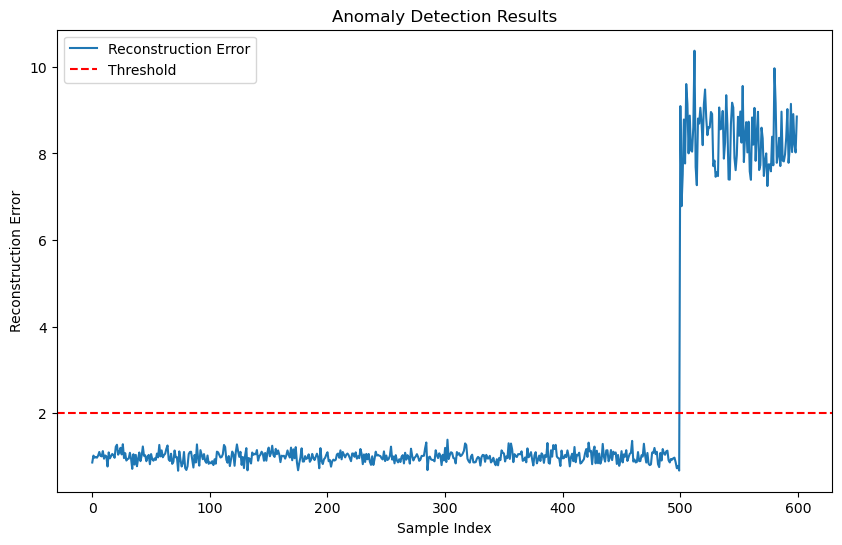

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt

# Diffusion-SkipGANomaly Encoder (Skip Connection 포함)
class DiffusionEncoder(Model):
    def __init__(self, latent_dim, timesteps=100):
        super(DiffusionEncoder, self).__init__()
        self.timesteps = timesteps
        self.latent_dim = latent_dim

        # 노이즈 스케줄링 (float32 변환 추가)
        self.beta = np.linspace(0.0001, 0.02, timesteps, dtype=np.float32)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = tf.convert_to_tensor(np.cumprod(self.alpha, dtype=np.float32))

        # CNN 기반 Encoder (Skip Connection용 출력 포함)
        self.conv1 = layers.Conv1D(64, 7, strides=2, padding="same", activation="relu")
        self.conv2 = layers.Conv1D(128, 5, strides=2, padding="same", activation="relu")
        self.conv3 = layers.Conv1D(256, 3, strides=2, padding="same", activation="relu")
        self.conv4 = layers.Conv1D(latent_dim, 3, strides=2, padding="same", activation="relu")  # Decoder 입력 크기에 맞춤

    def forward_diffusion(self, x):
        """ 여러 Step에 걸쳐 Forward Diffusion 수행 """
        t = tf.random.uniform(shape=[], minval=1, maxval=self.timesteps, dtype=tf.int32)
        noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0, dtype=tf.float32)

        # float32 변환 적용
        alpha_cumprod_t = tf.gather(self.alpha_cumprod, t)
        alpha_cumprod_t = tf.cast(alpha_cumprod_t, tf.float32)

        # Forward diffusion 공식 적용
        x_t = tf.sqrt(alpha_cumprod_t) * x + tf.sqrt(1.0 - alpha_cumprod_t) * noise

        return x_t, t, noise

    def call(self, inputs):
        """ Skip Connection 추가하여 4개 값 반환 """
        x_t, t, noise = self.forward_diffusion(inputs)

        # Skip Connection 저장
        skip1 = self.conv1(x_t)
        skip2 = self.conv2(skip1)
        skip3 = self.conv3(skip2)
        latent = self.conv4(skip3)

        return latent, [skip1, skip2, skip3], t, noise  # 💡 4개 반환

# Diffusion-SkipGANomaly Decoder (Skip Connection 적용)
class DiffusionDecoder(Model):
    def __init__(self, output_dim, latent_dim, timesteps=100):
        super(DiffusionDecoder, self).__init__()
        self.timesteps = timesteps
        self.latent_dim = latent_dim

        # Decoder 입력 차원 조정 (Encoder와 일치하도록)
        self.reshape_layer = layers.Conv1DTranspose(256, 3, strides=1, padding="same", activation="relu")

        # U-Net 스타일 Noise Prediction Network (Skip Connection 활용)
        self.deconv1 = layers.Conv1DTranspose(256, 3, strides=2, padding="same", activation="relu")
        self.deconv2 = layers.Conv1DTranspose(128, 3, strides=2, padding="same", activation="relu")
        self.deconv3 = layers.Conv1DTranspose(64, 5, strides=2, padding="same", activation="relu")
        self.deconv4 = layers.Conv1DTranspose(output_dim, 7, strides=2, padding="same", activation="tanh")

    def reverse_diffusion(self, latent, noise, t, skip_features):
        """ 학습된 모델을 통해 역방향 샘플링 수행 """
        x_t = self.reshape_layer(latent)  # 🛠 Decoder 입력 차원 조정

        # Upsample and concatenate skip features
        x_t = self.deconv1(x_t)
        x_t = tf.concat([x_t, skip_features[2]], axis=-1)  # Concatenate with skip3

        x_t = self.deconv2(x_t)
        x_t = tf.concat([x_t, skip_features[1]], axis=-1)  # Concatenate with skip2

        x_t = self.deconv3(x_t)
        x_t = tf.concat([x_t, skip_features[0]], axis=-1)  # Concatenate with skip1

        x_t = self.deconv4(x_t)

        return x_t

    def call(self, latent, noise, t, skip_features):
        return self.reverse_diffusion(latent, noise, t, skip_features)

# GAN 기반 Discriminator
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv1D(64, 7, strides=2, padding="same")
        self.conv2 = layers.Conv1D(128, 5, strides=2, padding="same")
        self.conv3 = layers.Conv1D(256, 3, strides=2, padding="same")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1, activation="sigmoid")

        # LeakyReLU 적용 (alpha -> negative_slope로 변경)
        self.activation = layers.LeakyReLU(negative_slope=0.2)

    def call(self, inputs):
        x = self.activation(self.conv1(inputs))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.flatten(x)
        return self.dense(x)

# Diffusion-SkipGANomaly 모델 (Skip Connection 적용)
class DiffusionSkipGANomaly(Model):
    def __init__(self, input_dim, latent_dim):
        super(DiffusionSkipGANomaly, self).__init__()
        self.encoder = DiffusionEncoder(latent_dim)
        self.decoder = DiffusionDecoder(input_dim, latent_dim)
        self.discriminator = Discriminator()

    def call(self, inputs):
        latent, skip_features, t, noise = self.encoder(inputs)  # Skip Features 포함
        reconstructed = self.decoder(latent, noise, t, skip_features)  # Skip Connection 적용하여 복원
        disc_real = self.discriminator(inputs)
        disc_fake = self.discriminator(reconstructed)
        return reconstructed, disc_real, disc_fake, latent

# 이상치 탐지 함수
def detect_anomalies(model, test_data, threshold=0.5):
    """ 테스트 데이터에서 이상치 탐지 """
    reconstructions, _, _, _ = model(test_data)
    reconstruction_error = tf.reduce_mean(tf.square(test_data - reconstructions), axis=[1, 2])
    anomalies = reconstruction_error > threshold
    return anomalies.numpy(), reconstruction_error.numpy()

# 데이터 생성 (정상 데이터와 비정상 데이터)
def generate_data(normal_samples=1000, anomaly_samples=100, seq_length=128, input_dim=1):
    """ 정상 데이터와 비정상 데이터 생성 """
    normal_data = np.random.normal(0, 1, (normal_samples, seq_length, input_dim))
    anomaly_data = np.random.uniform(-5, 5, (anomaly_samples, seq_length, input_dim))
    labels = np.concatenate([np.zeros(normal_samples), np.ones(anomaly_samples)])
    data = np.concatenate([normal_data, anomaly_data])
    return data, labels

# 메인 실행 코드
if __name__ == "__main__":
    # 하이퍼파라미터
    input_dim = 1
    latent_dim = 100
    seq_length = 128
    threshold = 2

    # 모델 초기화
    model = DiffusionSkipGANomaly(input_dim, latent_dim)

    # 데이터 생성
    train_data, _ = generate_data(normal_samples=1000, anomaly_samples=0)  # 정상 데이터만 학습
    test_data, test_labels = generate_data(normal_samples=500, anomaly_samples=100)  # 정상 + 비정상 데이터 테스트

    # 모델 학습 (간단한 예제이므로 실제 학습 코드는 생략)
    # model.compile(...)
    # model.fit(train_data, epochs=10)

    # 이상치 탐지
    anomalies, reconstruction_error = detect_anomalies(model, test_data, threshold)

    # 성능 평가
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, anomalies, average="binary")
    auc_score = roc_auc_score(test_labels, reconstruction_error)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc_score:.4f}")

    # 이상치 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(reconstruction_error, label="Reconstruction Error")
    plt.axhline(threshold, color="r", linestyle="--", label="Threshold")
    plt.xlabel("Sample Index")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.title("Anomaly Detection Results")
    plt.show()